# Hankel SGD 

- LSFM data from zebrafish larvae
- procedure:

-- i) fit PCA to largest subpop

-- ii) fit time-lagged covariances $\{X_m\}_m$ to largest subpop with $C$ from PCA, $\alpha_C \approx 0$ (updating mostly $X_m$ for $m > 0$)

-- iii) take $\{X_m\}_m$, and parts of C from largest subpop to initialise full-pop model (set $C[i,:]=0$ for $i$ not in largest subpop) 

-- iv) fit full-pop model for initially $\alpha_X \approx 0$, learning the new $C[i,:]$ and $R[i]$

-- v) proceed with regular fit, slowly decreasing learning rates / increasing batch sizes as necessary



In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import bz2

import glob, os, psutil, time
os.chdir('../core')
from text import progprint_xrange
from utility import get_subpop_stats, gen_data
from SSID_Hankel_loss import run_bad, plot_slim, print_slim
os.chdir('../dev')

data_path = '../fits/lsfm/grid_quick/'
Ts = np.arange(0, 1200, 1)
nx, ny, nz = 41, 1024, 2048
dx, dy, dz = 4, 32, 64
x_sel, y_sel, z_sel = np.arange(0,nx,dx), np.arange(0,ny,dy), np.arange(0,nz,dz)

n = 20
T = len(Ts)
p = len(x_sel) * len(y_sel) * len(z_sel) 


lag_range = np.arange(0, 21, 4)


print('(p,n,k+l,T) = ', (p,n,len(lag_range),T), '\n')

mmap = True

(p,n,k+l,T) =  (11264, 20, 6, 1200) 



In [ ]:
    import numpy as np
    data_path = '../fits/lsfm/grid_quick/'
    save_file = 'full_2pops_zsplit_6_lags'
    tmp = np.load(data_path + save_file + '.npz')
    p,n,T = tmp['p'],tmp['n'],tmp['T']
    lag_range = tmp['lag_range']
    pars_est, pars_pca = tmp['pars_est'].tolist(), tmp['pars_pca'].tolist()
    sub_pops = tmp['sub_pops']
    obs_pops = np.arange(len(sub_pops))
    obs_time = T//len(sub_pops) * np.arange(1,len(sub_pops)+1)
    mmap = True
    del tmp

In [ ]:
lag_range

# create subpopulations and observation scheme

In [2]:
# create subpopulations
tmp = np.arange(p)
tmp =tmp.reshape(len(x_sel),len(y_sel),len(z_sel))

# splitting imaging planes, 2 subpops
sub_pops = (tmp[:len(x_sel)//2+1,:,:].reshape(-1),
            tmp[len(x_sel)//2:,:,:].reshape(-1))
obs_pops = np.array([0,1])
obs_time = np.array([T//2, T])

# splitting imaging planes, 5 subpops
#sub_pops = (tmp[0:3,:,:].reshape(-1),
#            tmp[2:5,:,:].reshape(-1),            
#            tmp[4:7,:,:].reshape(-1),            
#            tmp[6:9,:,:].reshape(-1),            
#            tmp[8:11,:,:].reshape(-1))
#obs_pops = np.array([0,1,2,3,4])
#obs_time = T//len(sub_pops) * np.arange(1,len(sub_pops)+1)

#sub_pops = (np.arange(p),)
#obs_pops = np.array([0])
#obs_time = np.array([T])
del tmp


# Do PCA for comparison

In [ ]:
from sklearn.decomposition import PCA

p1 = len(sub_pops[0])
pa = np.min((p1,1000))
pb = np.min((p1,1000))
idx_a = np.sort(np.random.choice(p1, pa, replace=False))
idx_b = np.sort(np.random.choice(p1, pb, replace=False))


Qs = []
kl_ = np.max(lag_range)+1
if mmap:
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p))
    y = y[:,sub_pops[0]]
for m in range(len(lag_range)):
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Qs.append(None)
    if mmap:
        Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                      mode='w+', shape=(pa,pb))
    else:
        Q = np.empty((pa,pb))
    Q[:] = np.cov(y[m_:m_-(kl_),idx_a].T, y[:-(kl_),idx_b].T)[:pa,pa:]     
    if mmap:
        del Q
        Qs[m] = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                          mode='r', shape=(pa,pb))
    else:
        Qs[m] = Q
if mmap:
    del y # releases RAM, forces flush to disk
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p)) 
    y = y[:,sub_pops[0]]


obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=(np.arange(len(sub_pops[0])),), p=len(sub_pops[0]), verbose=False)


pca = PCA()
pca.fit(y)
explained_variance_ratio_ = np.hstack((pca.explained_variance_ratio_, np.zeros(np.max((p1-T,0)))))
plt.plot(range(1,p1+1), np.cumsum(explained_variance_ratio_)/np.sum(explained_variance_ratio_))
plt.hold(True)
plt.plot(np.linspace(0,p+1,np.min((20,p))), 
         np.cumsum(pca.explained_variance_ratio_[:np.min((20,p))])/np.sum(pca.explained_variance_ratio_), 
         'r--')
plt.legend(('cum. var. expl.', 'first 20, x-axis rescaled'))

pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])    
#np.savez(data_path+'pars_pca', 
#     pars=pars_pca)

# initialise X_m, C[sub_pop[i],:] from fit on single subpopulation

In [ ]:
t = time.time()
verbose = True

# fit for a single round to cheaply get initial parameter shapes
pars_init, pars_est1, traces = run_bad(lag_range=lag_range, n=n,y=y, Om=None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      sub_pops=(np.arange(p1),),
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=np.array([0]),obs_time=np.array([T]),
                                      init='default',alpha_C=0,
                                      max_iter=1,batch_size=1,max_zip_size=1)

# settings for fitting algorithm
batch_size, max_zip_size, max_iter = 1, 1, 1
a_C, a_R, a_X = 0, 0, 0
b1, b2, e = 0.9, 0.99, 1e-8
pars_est1['C'] = pars_pca['C'].copy()
pars_est1['X'][:n,:] = pars_pca['Pi'].copy()
_, pars_est1, traces = run_bad(lag_range=lag_range,n=n,y=y, Om = None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      init=pars_est1,sub_pops=(np.arange(p1),),
                                      obs_pops=np.array([0]),obs_time=np.array([T]),
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      alpha_C=a_C, alpha_R=a_R, alpha_X=a_X, 
                                      b1_C=b1,b2_C=b2,e_C=e,
                                      max_iter=max_iter,batch_size=batch_size,
                                      verbose=verbose, max_zip_size=max_zip_size)
print('\n PCA initialisation quality: \n')
print_slim(Qs,lag_range,pars_est1,idx_a,idx_b,traces,mmap,data_path)

a_C, a_R, a_X = 0.00000001, 0.001, 0.01
batch_size, max_zip_size, max_iter = 1, 100, 10
_, pars_est1, traces = run_bad(lag_range=lag_range,n=n,y=y, Om = None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      init=pars_est1,sub_pops=(np.arange(p1),),
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=np.array([0]),obs_time=np.array([T]),
                                      alpha_C=a_C, alpha_R=a_R, alpha_X=a_X, 
                                      b1_C=b1,b2_C=b2,e_C=e,
                                      max_iter=max_iter,batch_size=batch_size,
                                      verbose=verbose, max_zip_size=max_zip_size)

print('\n initialisation quality : \n')
print_slim(Qs,lag_range,pars_est1,idx_a,idx_b,traces,mmap,data_path)

print(y.shape)

In [ ]:
a_C, a_R, a_X = 0.00000001, 0.001, 0.1
batch_size, max_zip_size, max_iter = 1, 100, 10
_, pars_est1, traces = run_bad(lag_range=lag_range,n=n,y=y, Om = None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      init=pars_est1,sub_pops=(np.arange(p1),),
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=np.array([0]),obs_time=np.array([T]),
                                      alpha_C=a_C, alpha_R=a_R, alpha_X=a_X, 
                                      b1_C=b1,b2_C=b2,e_C=e,
                                      max_iter=max_iter,batch_size=batch_size,
                                      verbose=verbose, max_zip_size=max_zip_size)

print('\n initialisation quality : \n')
print_slim(Qs,lag_range,pars_est1,idx_a,idx_b,traces,mmap,data_path)

In [ ]:
plot_slim(Qs,lag_range,pars_est1,idx_a,idx_b,traces,mmap,data_path)

# do fit for all subpopulations

In [ ]:

obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)

    
pa = np.min((p,1000))
pb = np.min((p,1000))
idx_a = np.sort(np.random.choice(p, pa, replace=False))
idx_b = np.sort(np.random.choice(p, pb, replace=False))


Qs = []
kl_ = np.max(lag_range)+1
if mmap:
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p))
for m in range(len(lag_range)):
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Qs.append(None)
    if mmap:
        Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                      mode='w+', shape=(pa,pb))
    else:
        Q = np.empty((pa,pb))
    Q[:] = np.cov(y[m_:m_-(kl_),idx_a].T, y[:-(kl_),idx_b].T)[:pa,pa:]     
    if mmap:
        del Q
        Qs[m] = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                          mode='r', shape=(pa,pb))
    else:
        Qs[m] = Q
if mmap:
    del y # releases RAM, forces flush to disk
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p)) 
    
t = time.time()

pars_init, pars_0, traces = run_bad(lag_range=lag_range,n=n,y=y, Om = None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      sub_pops=sub_pops,
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=obs_pops,obs_time=obs_time,
                                      alpha_C=0, b1_C=b1,b2_C=b2,e_C=e,
                                      max_iter=1,batch_size=1,max_zip_size=1)
pars_0['C'] *= 0
pars_0['C'][sub_pops[0], :] = pars_est1['C'].copy()
pars_0['R'][sub_pops[0]] = pars_est1['R'].copy()
pars_0['X'] = pars_est1['X'].copy()
pars_est = pars_0.copy()
print_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)
del pars_0

batch_size, max_zip_size, max_iter = 1, 100, 10
b1, b2, e = 0.9, 0.99, 1e-8
a_C, a_R, a_X = 0.0001, 0.001, 0.0001

_, pars_est, traces = run_bad(lag_range=lag_range,n=n,y=y, Om = None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      sub_pops=sub_pops,
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=obs_pops,obs_time=obs_time,init=pars_est,
                                      alpha_C=a_C, alpha_R=a_R, alpha_X=a_X, 
                                      b1_C=b1,b2_C=b2,e_C=e,
                                      max_iter=max_iter,batch_size=batch_size,
                                      max_zip_size=max_zip_size)
plot_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)

batch_size, max_zip_size, max_iter = 10, 10, 10
b1, b2, e = 0.9, 0.99, 1e-8
a_C, a_R, a_X = 0.0001, 0.001, 0.0001

_, pars_est, traces = run_bad(lag_range=lag_range,n=n,y=y, Om = None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      sub_pops=sub_pops,
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=obs_pops,obs_time=obs_time,init=pars_est,
                                      alpha_C=a_C, alpha_R=a_R, alpha_X=a_X, 
                                      b1_C=b1,b2_C=b2,e_C=e,
                                      max_iter=max_iter,batch_size=batch_size,
                                      max_zip_size=max_zip_size)
plot_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)



print('fitting time was ', time.time() - t, 's')
print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())



In [ ]:
obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)

    
pa = np.min((p,1000))
pb = np.min((p,1000))
idx_a = np.sort(np.random.choice(p, pa, replace=False))
idx_b = np.sort(np.random.choice(p, pb, replace=False))

Qs = []
kl_ = np.max(lag_range)+1
if mmap:
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p))
for m in range(len(lag_range)):
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Qs.append(None)
    if mmap:
        Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                      mode='w+', shape=(pa,pb))
    else:
        Q = np.empty((pa,pb))
    Q[:] = np.cov(y[m_:m_-(kl_),idx_a].T, y[:-(kl_),idx_b].T)[:pa,pa:]     
    if mmap:
        del Q
        Qs[m] = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                          mode='r', shape=(pa,pb))
    else:
        Qs[m] = Q
if mmap:
    del y # releases RAM, forces flush to disk
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p)) 

In [ ]:
batch_size, max_zip_size, max_iter = 1, 100, 20
b1, b2, e = 0.9, 0.99, 1e-8
a_C, a_R, a_X = 0.00001, 0.00001, 0.01

_, pars_est, traces = run_bad(lag_range=lag_range,n=n,y=y, Om = None, Qs=Qs, idx_a=idx_a,idx_b=idx_b,
                                      sub_pops=sub_pops,
                                      idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=obs_pops,obs_time=obs_time,init=pars_est,
                                      alpha_C=a_C, alpha_R=a_R, alpha_X=a_X, 
                                      b1_C=b1,b2_C=b2,e_C=e,
                                      max_iter=max_iter,batch_size=batch_size,
                                      max_zip_size=max_zip_size)
print_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)


In [ ]:
plot_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)

In [ ]:
if False:
    import numpy as np
    data_path = '../fits/lsfm/grid_quick/'
    save_file = 'full_2pops_zsplit_6_lags'
    tmp = np.load(data_path + save_file + '.npz')
    p,n,T = tmp['p'],tmp['n'],tmp['T']
    lag_range = tmp['lag_range']
    pars_est, pars_pca = tmp['pars_est'].tolist(), tmp['pars_pca'].tolist()
    sub_pops = tmp['sub_pops']
    mmap = True
    del tmp

In [26]:
    import numpy as np
    data_path = '../fits/lsfm/grid_quick/'
    save_file = 'full_2pops_zsplit_6_lags'
    tmp = np.load(data_path + save_file + '.npz')
    p,n,T = tmp['p'],tmp['n'],tmp['T']
    lag_range = tmp['lag_range']
    pars_est, pars_pca = tmp['pars_est'].tolist(), tmp['pars_pca'].tolist()
    #sub_pops = tmp['sub_pops']
    obs_pops = np.arange(len(sub_pops))
    obs_time = T//len(sub_pops) * np.arange(1,len(sub_pops)+1)
    mmap = True
    del tmp

In [27]:
from sklearn.decomposition import PCA

fig_path = '/home/mackelab/Desktop/Projects/Stitching/code/le_stitch/python/figs/'
m_range = range(len(lag_range))
kl_ = np.max(lag_range)+1

y_masked = np.memmap(data_path+'y_zscore', dtype=np.float, mode='c', shape=(T,p))

#y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = 0
#for i in range(1,len(obs_time)):
#    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = 0
    
pca = PCA()
pca.fit(y_masked)
del y_masked

pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])    


idxc_a = sub_pops[0]
if len(sub_pops) > 0:
    idxc_b = np.setdiff1d(np.arange(p), sub_pops[0]) # those only in subpop #2 
else:
    idxc_b = idx_a.copy()
pa, pb = len(idxc_a), len(idxc_b)

pa, pb = 1000, 1000
idxc_a = idxc_a[np.sort(np.random.choice(idxc_a.size, pa, replace=False))] # subsample for \
idxc_b = idxc_b[np.sort(np.random.choice(idxc_b.size, pb, replace=False))] # memory reasons


Qs = []
if mmap:
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p))
    

corrs_est = np.zeros((len(m_range), 2))
MSE_est = np.zeros((len(m_range), 2))    
for m in m_range:
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Qs.append(None)
    if mmap:
        Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                      mode='w+', shape=(pa,pb))
    else:
        Q = np.empty((pa,pb))
    Q[:] = np.cov(y[m_:m_-(kl_),idxc_a].T, y[:-(kl_),idxc_b].T)[:pa,pa:]     
    if mmap:
        del Q
        Qs[m] = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                          mode='r', shape=(pa,pb))
    else:
        Qs[m] = Q
            
    Q = (pars_est['C'][idxc_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idxc_b,:].T))
    corrs_est[m,0] = np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]
    MSE_est[m,0] = np.mean( (Qs[m] - Q)**2 )

    """
    plt.figure(figsize=(20,20))
    if m_ == 0:
        plt.plot(-10,-10, 'r.')    
        plt.hold(True)
        plt.plot(-10,-10, 'b.')    
        plt.plot(Qs[m][:], Q[:], 'r.')
        plt.hold(True)
        plt.title('corr. est. us:' + str(np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]))
    """
    
    tmp  = np.abs(Q.reshape(-1) - Qs[m].reshape(-1))
        
    Q = (pars_pca['C'][idxc_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idxc_b,:].T))
    corrs_est[m,1] = np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]      
    MSE_est[m,1] = np.mean( (Qs[m] - Q)**2 )    
    
    """
    if m_ == 0:
        plt.plot(Qs[m][:], Q[:], 'b.')
        plt.plot([-1,1], [-1,1], 'k--')

        plt.legend(('stitched', 'naive PCA'), 'northwest')    
        plt.axis([-1,1,-1,1])
        plt.xlabel('corr. est. PCA:' + str(np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]))
        plt.savefig(fig_path + 'stitched_covs.png', bbox_inches="tight"); 
        plt.show()
    """
    
    del Q
    if mmap:
        del y # releases RAM, forces flush to disk
        y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p)) 


computing time-lagged covariance for lag  0
computing time-lagged covariance for lag  4
computing time-lagged covariance for lag  8
computing time-lagged covariance for lag  12
computing time-lagged covariance for lag  16
computing time-lagged covariance for lag  20


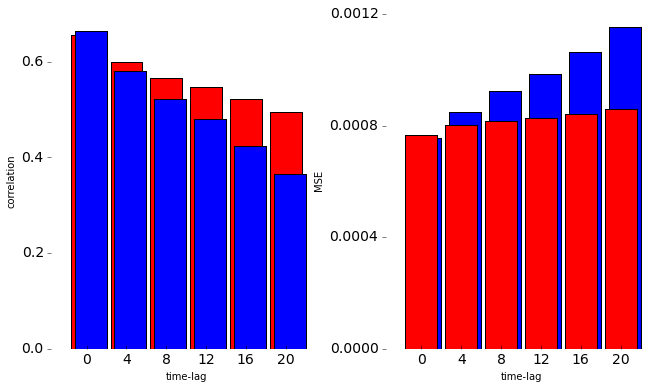

In [29]:
plt.figure(figsize=(11,6))
ax = plt.subplot(121)
plt.bar(-.4+np.arange(len(lag_range)), corrs_est[:,0], color='r')
plt.hold(True)
plt.bar(-.4+np.arange(len(lag_range))+.1, corrs_est[:,1], color='b')
plt.xticks(np.arange(len(lag_range)), [str(x) for x in lag_range], fontsize=14)
plt.yticks(np.arange(0,0.61, 0.2), fontsize=14)
plt.xlabel('time-lag')
plt.ylabel('correlation')
plt.box('off')
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

ax = plt.subplot(122)
plt.bar(-.4+np.arange(len(lag_range))+.1, MSE_est[:,1], color='b')
plt.hold(True)
plt.bar(-.4+np.arange(len(lag_range)), MSE_est[:,0], color='r')
plt.xticks(np.arange(len(lag_range)), [str(x) for x in lag_range], fontsize=14)
plt.yticks(np.arange(0,0.0013,0.0004), fontsize=14)
plt.xlabel('time-lag')
plt.ylabel('MSE')
plt.box('off')
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.savefig(fig_path + 'd_lsfm_full_us_vs_pca.pdf', bbox_inches="tight");     


In [18]:
    import numpy as np
    data_path = '../fits/lsfm/grid_quick/'
    save_file = 'stitch_2pops_zsplit_6_lags'
    tmp = np.load(data_path + save_file + '.npz')
    p,n,T = tmp['p'],tmp['n'],tmp['T']
    lag_range = tmp['lag_range']
    pars_est, pars_pca = tmp['pars_est'].tolist(), tmp['pars_pca'].tolist()
    #sub_pops = tmp['sub_pops']
    obs_pops = np.arange(len(sub_pops))
    obs_time = T//len(sub_pops) * np.arange(1,len(sub_pops)+1)
    mmap = True
    del tmp

done PCA
computing time-lagged covariance for lag  0


/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "northwest". Falling back on "best"; valid locations are
	lower right
	lower center
	right
	lower left
	upper right
	center left
	center
	best
	upper left
	upper center
	center right

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))


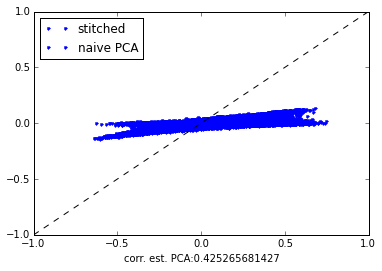

computing time-lagged covariance for lag  4
computing time-lagged covariance for lag  8
computing time-lagged covariance for lag  12
computing time-lagged covariance for lag  16
computing time-lagged covariance for lag  20


In [22]:
from sklearn.decomposition import PCA

fig_path = '/home/mackelab/Desktop/Projects/Stitching/code/le_stitch/python/figs/'
m_range = range(len(lag_range))
kl_ = np.max(lag_range)+1

y_masked = np.memmap(data_path+'y_zscore', dtype=np.float, mode='c', shape=(T,p))

y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = 0
for i in range(1,len(obs_time)):
    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = 0
    
pca = PCA()
pca.fit(y_masked)
del y_masked

pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])    

print('done PCA')


idxc_a = np.setdiff1d(np.arange(p), sub_pops[1])
if len(sub_pops) > 0:
    idxc_b = np.setdiff1d(np.arange(p), sub_pops[0]) # those only in subpop #2 
else:
    idxc_b = idx_a.copy()
pa, pb = len(idxc_a), len(idxc_b)

#pa, pb = 1000, 1000
#idxc_a = idxc_a[np.sort(np.random.choice(idxc_a.size, pa, replace=False))] # subsample for \
#idxc_b = idxc_b[np.sort(np.random.choice(idxc_b.size, pb, replace=False))] # memory reasons


Qs = []
if mmap:
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p))
    

corrs_est = np.zeros((len(m_range), 2))
MSE_est = np.zeros((len(m_range), 2))    
for m in m_range:
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Qs.append(None)
    if mmap:
        Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                      mode='w+', shape=(pa,pb))
    else:
        Q = np.empty((pa,pb))
    Q[:] = np.cov(y[m_:m_-(kl_),idxc_a].T, y[:-(kl_),idxc_b].T)[:pa,pa:]     
    if mmap:
        del Q
        Qs[m] = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                          mode='r', shape=(pa,pb))
    else:
        Qs[m] = Q
            
    Q = (pars_est['C'][idxc_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idxc_b,:].T))
    corrs_est[m,0] = np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]
    MSE_est[m,0] = np.mean( (Qs[m] - Q)**2 )

    """
    plt.figure(figsize=(20,20))
    if m_ == 0:
        plt.plot(-10,-10, 'r.')    
        plt.hold(True)
        plt.plot(-10,-10, 'b.')    
        plt.plot(Qs[m][:], Q[:], 'r.')
        plt.hold(True)
        plt.title('corr. est. us:' + str(np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]))
    """
    
    tmp  = np.abs(Q.reshape(-1) - Qs[m].reshape(-1))
        
    Q = (pars_pca['C'][idxc_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idxc_b,:].T))
    corrs_est[m,1] = np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]      
    MSE_est[m,1] = np.mean( (Qs[m] - Q)**2 )    
    
    """
    if m_ == 0:
        plt.plot(Qs[m][:], Q[:], 'b.')
        plt.plot([-1,1], [-1,1], 'k--')

        plt.legend(('stitched', 'naive PCA'), 'northwest')    
        plt.axis([-1,1,-1,1])
        plt.xlabel('corr. est. PCA:' + str(np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]))
        plt.savefig(fig_path + 'stitched_covs.png', bbox_inches="tight"); 
        plt.show()
    """
    
    del Q
    if mmap:
        del y # releases RAM, forces flush to disk
        y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p)) 


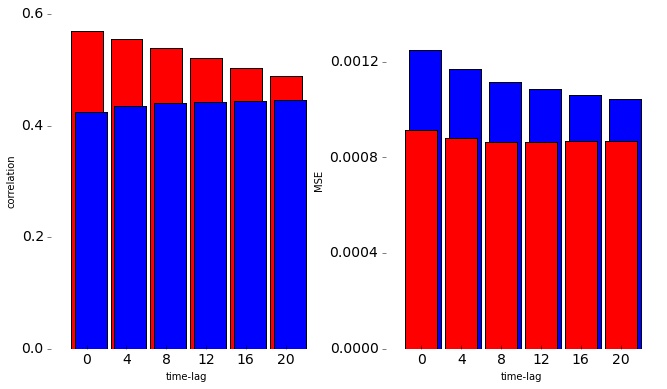

In [25]:
plt.figure(figsize=(11,6))
ax = plt.subplot(121)
plt.bar(-.4+np.arange(len(lag_range)), corrs_est[:,0], color='r')
plt.hold(True)
plt.bar(-.4+np.arange(len(lag_range))+.1, corrs_est[:,1], color='b')
plt.xticks(np.arange(len(lag_range)), [str(x) for x in lag_range], fontsize=14)
plt.yticks(np.arange(0,0.61, 0.2), fontsize=14)
plt.xlabel('time-lag')
plt.ylabel('correlation')
plt.box('off')
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

ax = plt.subplot(122)
plt.bar(-.4+np.arange(len(lag_range))+.1, MSE_est[:,1], color='b')
plt.hold(True)
plt.bar(-.4+np.arange(len(lag_range)), MSE_est[:,0], color='r')
plt.xticks(np.arange(len(lag_range)), [str(x) for x in lag_range], fontsize=14)
plt.yticks(np.arange(0,0.0013,0.0004), fontsize=14)
plt.xlabel('time-lag')
plt.ylabel('MSE')
plt.box('off')
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.savefig(fig_path + 'd_lsfm_stitch_us_vs_pca.pdf', bbox_inches="tight");        
plt.show()

In [24]:
pa, pb

(5120, 5120)

In [ ]:
if False:
    save_file = 'stitch_2pops_zsplit_6_lags'
    np.savez(data_path + save_file, 
             pars_true=None, 
             pars_est=pars_est,
             pars_pca=pars_pca,
             sub_pops=sub_pops,
             p=p,n=n,T=T,lag_range=lag_range)          